## Settings

In [1]:
import os
import cv2
from glob import glob
from imgaug import augmenters as iaa
%matplotlib inline
import matplotlib.pyplot as plt

ROOT_DIR = '/home/wangwenzhe/tf-faster-rcnn-rddc'
ANALYSIS_DIR = os.path.join(ROOT_DIR, 'analysis')
IMAGE_DIR = '/home/wangwenzhe/tf-faster-rcnn-rddc/data/VOCdevkit2007/VOC2007/JPEGImages/'
ANNO_DIR = '/home/wangwenzhe/tf-faster-rcnn-rddc/data/VOCdevkit2007/VOC2007/Annotations/'
TXT_DIR = '/home/wangwenzhe/tf-faster-rcnn-rddc/data/VOCdevkit2007/VOC2007/ImageSets/Main/'

/home/wangwenzhe/tf-faster-rcnn/python3_env/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/wangwenzhe/tf-faster-rcnn/python3_env/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/wangwenzhe/tf-faster-rcnn/python3_env/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data balance analysis

In [2]:
file_name = 'window_file_voc2007_trainval.txt'

# load the annotations
bboxs = []
anno_dict = {}
with open(os.path.join(ANALYSIS_DIR, file_name)) as f:
    im_name = f.readline().strip()
    while(im_name):
        obj_num = int(f.readline().strip())
        for i in range(obj_num):
            bboxs.append(f.readline().strip().split(' '))
        anno_dict[im_name] = bboxs[-obj_num:] if obj_num > 0 else []
        im_name = f.readline().strip()

Number of pictures: 7240 + 2400 = 9640
Number of pictures (each class): [2679, 3732, 1182, 1032, 2444, 1268, 1312, 3540]


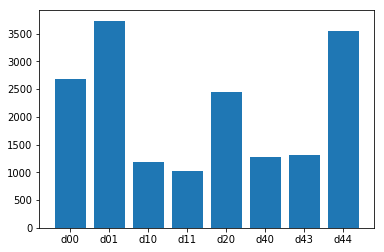

In [3]:
CLASSES = ('d00', 'd01', 'd10', 'd11', 'd20', 'd40', 'd43', 'd44')

# suppose we augment the data of class 3, 4, 6, 7
do_aug = 0
aug_num = 0
for im_name in anno_dict:
    for bbox in anno_dict[im_name]:
        if int(bbox[0]) in [3,4,7]:
            do_aug = 1 if do_aug < 1 else do_aug # 2 times
        elif int(bbox[0]) in [6]:
            do_aug = 3 if do_aug < 3 else do_aug # 4 times
    for bbox in anno_dict[im_name]:
        for i in range(do_aug):
            bboxs.append(bbox)
    aug_num += do_aug
    do_aug = 0
print('Number of pictures: {} + {} = {}'.format(len(anno_dict), aug_num, len(anno_dict) + aug_num))
    
# number of pictures after augmentation (each class)
class_num = [0 for i in range(8)]
for b in bboxs:
    class_num[int(b[0]) - 1] += 1
print('Number of pictures (each class): {}'.format(class_num))
plt.bar(CLASSES, class_num, 0.8)
plt.show()

## Training data augmentation

In [ ]:
# augment the training data
seq = iaa.OneOf([
    iaa.ContrastNormalization((1.2,2)),
    iaa.ContrastNormalization(0.5,0.7),
    iaa.Multiply((1.2,1.5)),
    iaa.Multiply((0.5,0.7)),
    iaa.GaussianBlur((0.8,1.2))
])

seq_cont = iaa.OneOf([
    iaa.ContrastNormalization((1.2,2)),
    iaa.ContrastNormalization(0.5,0.7)
])

seq_mult = iaa.OneOf([
    iaa.Multiply((1.2,1.5)),
    iaa.Multiply((0.5,0.7))
])

seq_guas = iaa.OneOf([
    iaa.GaussianBlur((0.8,1.2))
])

images = glob(IMAGE_DIR + 'train_[A-Z]*.jpg')
images.sort()
do_aug = 0
count = 0
for im_name in images:
    for bbox in anno_dict[im_name]:
        if int(bbox[0]) in [3,4,7]:
            do_aug = 1 if do_aug < 1 else do_aug # 2 times
        elif int(bbox[0]) in [6]:
            do_aug = 3 if do_aug < 3 else do_aug # 4 times
    im = cv2.imread(im_name)
    anno = im_name.replace('JPEGImages', 'Annotations').replace('jpg', 'xml')
    if do_aug == 1:
        im_aug0 = seq.augment_image(im)
        cv2.imwrite(im_name.replace('train', 'train_aug0'), im_aug0)
        with open(anno) as fr, open(anno.replace('train', 'train_aug0'),'w') as fw:
            fw.write(fr.read().replace('train', 'train_aug0'))
    elif do_aug == 3:
        im_aug1 = seq_cont.augment_image(im)
        cv2.imwrite(im_name.replace('train', 'train_aug1'), im_aug1)
        with open(anno) as fr, open(anno.replace('train', 'train_aug1'),'w') as fw:
            fw.write(fr.read().replace('train', 'train_aug1'))
        im_aug2 = seq_mult.augment_image(im)
        cv2.imwrite(im_name.replace('train', 'train_aug2'), im_aug2)
        with open(anno) as fr, open(anno.replace('train', 'train_aug2'),'w') as fw:
            fw.write(fr.read().replace('train', 'train_aug2'))
        im_aug3 = seq_guas.augment_image(im)
        cv2.imwrite(im_name.replace('train', 'train_aug3'), im_aug3)
        with open(anno) as fr, open(anno.replace('train', 'train_aug3'),'w') as fw:
            fw.write(fr.read().replace('train', 'train_aug3'))
    count += do_aug
    do_aug = 0
    print(str(count) + ' / ' + str(aug_num), end='\r', flush=True)

In [ ]:
# update trainval.txt
train_images = glob(IMAGE_DIR + 'train*.jpg')
with open(TXT_DIR + 'trainval.txt', 'w') as f:
    for im_name in train_images:
        f.write(im_name.split('/')[-1].split('.')[0] + '\n')

## Other tools that may be useful

### 1.  Validity the verify of training data augmentation

In [ ]:
# change test.txt to augmented data in trainval.txt
train_aug_images = glob(IMAGE_DIR + 'train_aug*.jpg')
with open(TXT_DIR + 'test.txt', 'w') as f:
    for im_name in train_aug_images:
        f.write(im_name.split('/')[-1].split('.')[0] + '\n')

In [ ]:
# change test.txt to original data in trainval.txt
train_images = glob(IMAGE_DIR + 'train_[A-Z]*.jpg')
train_images.sort()
with open(TXT_DIR + 'test.txt', 'w') as f:
    for im_name in train_images:
        f.write(im_name.split('/')[-1].split('.')[0] + '\n')

In [ ]:
# test on the above datasets using existing model separately, then compare the mAP values

### 2.  Test data augmentation

In [ ]:
# augment the test data
seq = iaa.OneOf([
    iaa.ContrastNormalization((1.2,2)),
    iaa.ContrastNormalization(0.5,0.7),
    iaa.Multiply((1.2,1.5)),
    iaa.Multiply((0.5,0.7)),
    iaa.GaussianBlur((0.8,1.2))
])

images = glob(IMAGE_DIR + 'test_[A-Z]*.jpg')
for im_name in images:
    print(str(images.index(im_name) + 1) + ' / ' + str(len(images)), end='\r', flush=True)
    im = cv2.imread(im_name)
    im_aug = seq.augment_image(im)
    cv2.imwrite(im_name.replace('test', 'test_aug'), im_aug)

In [ ]:
# update test.txt
test_images = glob(IMAGE_DIR + 'test*.jpg')
with open(TXT_DIR + 'test.txt', 'w') as f:
    for im_name in test_images:
        f.write(im_name.split('/')[-1].split('.')[0] + '\n')

In [ ]:
# then use some way to get more robust results using the augmented test data

### 3.  Delete the augmented data

In [ ]:
# delete the augmented training data
os.system('rm ' + IMAGE_DIR + 'train_aug*.jpg')
os.system('rm ' + ANNO_DIR + 'train_aug*.xml')

In [ ]:
# delete the augmented test data
os.system('rm ' + IMAGE_DIR + 'test_aug*.jpg')